In [1]:
## 入力データのファイル名
matching_fname = "all.out.matching"
pr_info_fname = "pressrelease_info.csv"
kabuka_fname = "kabuka_tse1"   # 将来的に東証一部以外のデータにまで拡張

In [2]:
## import
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
import math
from scipy import stats
from multiprocessing import Pool
from collections import Counter

## データの読み込み

In [3]:
## マッチング結果
matching_all = pd.read_table(matching_fname, sep = '\t', header = None, names = ['article_id', 'date', 'sentence', 'comp_code', 'comp_name', 'address_pr', 'add_ress_lc', 'score'])
#matching_all

In [4]:
## マッチングスコアの閾値
## 3 だと市区町村まで一致(23区は東京都だけの一致になるが、住所が「東京都」だけはまず無いので、結局区までの一致になる)
min_score = 3

matching = matching_all.copy().ix[matching_all["score"] >= min_score, :]
matching[0:3]

,article_id,date,sentence,comp_code,comp_name,address_pr,add_ress_lc,score
0,NIKPRLRSP038060_07012003,20030107,着信メロディ配信サービスヤマハ『美麗鈴(メロリン)』を開始ヤマハ株式会社(本社:,7951,ヤマハ,静岡県 None 浜松市 中区 中沢町 None None 10 1 None None,静岡県 None 浜松市 中区 中沢町 None None 10 1 None None,9
1,NIKPRLRSP038615_16012003,20030116,株式会社(東京都品川区、代表取締役:山本泉二、略称:SCN)、日本電気株式会社(,6701,日本電気,東京都 None None 港区 None None None None None None...,東京都 None None 港区 芝 None 5 7 1 None None,4
2,NIKPRLRSP038623_16012003,20030116,ランシーバ及びコントローラチップ販売開始(株)理経(代表取締役社長青柳勝栄、本社,8226,理経,東京都 None None 新宿区 西新宿 None 1 26 2 None None,東京都 None None 新宿区 西新宿 None 1 26 2 None None,9


In [5]:
## プレスリリースの種類
pr_type = {}
with open(pr_info_fname, 'r') as f:
    for line in f:
        article_id, date, comp_name, prtype = line.strip().split('\t')
        pr_type[article_id] = prtype

In [6]:
# 株価
# 以下のような形式のデータを読み込む
# -----------------------------------------------------------------------
# company_code,date:stock_value,date:stock_value,...
# ...
# -----------------------------------------------------------------------
#
# 返り値は以下のディクショナリ
# {company_code : TimeSeries_of_stock_values}

def load_kabuka(fname):
    comp_stock_values = {}
    
    with open(fname, 'r') as f:
        for line in f:
            data = line.strip().split(',')
            comp_code = data[0]
            dates = [datetime.strptime(x.split(':')[0], '%Y%m%d') for x in data[1:]]
            values = np.array([float(x.split(':')[1]) for x in data[1:]])
            comp_stock_values[comp_code] = Series(values, index = dates)
            
    return comp_stock_values

In [7]:
## 株価(TOPIX は company code = 1002)
kabuka = DataFrame(load_kabuka(kabuka_fname)).replace(0., np.nan)

In [8]:
kabuka['2000-01-01':'2000-01-07']

,1002,1003,1004,1005,1006,1007,1008,1103,1301,1305,...,9979,9982,9983,9984,9987,9989,9991,9993,9994,9997
2000-01-04,1717.47,1613.66,1434.18,1549.31,1071.64,1391.87,901.06,NaN,133.0,NaN,...,1155.0,NaN,42100.0,103000.0,2930.0,7500.0,391.0,NaN,930.0,2700.0
2000-01-05,1651.84,1520.86,1388.56,1473.90,1063.44,1338.36,894.58,NaN,135.0,NaN,...,1130.0,NaN,40150.0,86600.0,2765.0,7000.0,370.0,1420.0,900.0,2540.0
2000-01-06,1609.59,1470.06,1358.92,1430.90,1049.76,1304.93,884.32,NaN,135.0,NaN,...,1191.0,NaN,39500.0,81600.0,3100.0,6600.0,380.0,1380.0,850.0,2490.0
2000-01-07,1599.01,1448.99,1353.33,1415.54,1051.18,1295.03,886.78,NaN,137.0,NaN,...,1170.0,NaN,39050.0,76600.0,3250.0,6400.0,387.0,1350.0,840.0,2490.0


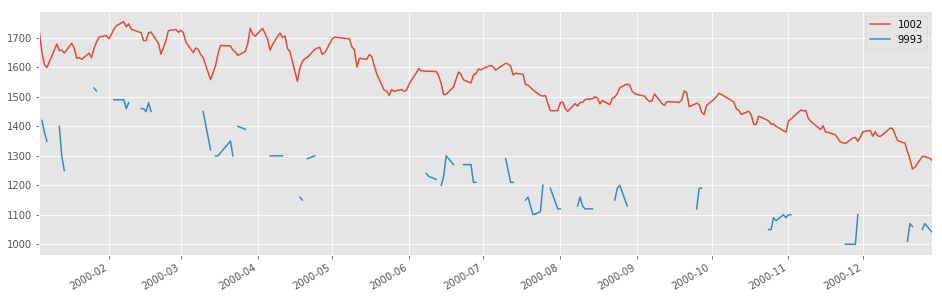

In [9]:
## 株価のプロットで欠損値を含む例
kabuka["1002"]['2000-01':'2000-12'].plot(figsize = (16, 5), legend = True)
kabuka["9993"]['2000-01':'2000-12'].plot(figsize = (16, 5), legend = True)

## リターン / アブノーマルリターン(AR) / 累積AR (CAR)の計算

In [9]:
## リターン
kabuka_r = kabuka.copy().pct_change()

In [10]:
kabuka_r["1002"]["2000-01":"2000-01-07"]

2000-01-04         NaN
2000-01-05   -0.038213
2000-01-06   -0.025578
2000-01-07   -0.006573
Name: 1002, dtype: float64

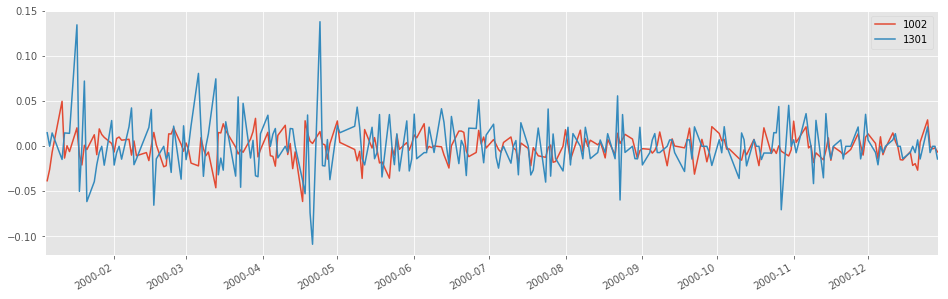

In [12]:
## リターンのプロットの例
kabuka_r["1002"]['2000-01':'2000-12'].plot(figsize = (16, 5), legend = True)
kabuka_r["1301"]['2000-01':'2000-12'].plot(figsize = (16, 5), legend = True)

In [11]:
## CAR 計算の定数
all_dates = kabuka_r.index   # 全営業日
min_date = min(all_dates)   # 株価データの初日
max_date = max(all_dates)   # 株価データの最終日

In [12]:
## kabuka_r からある特定の日(date)を基準として相対的に指定された日数からなる期間のデータを返す
## NOTE: 欠損値(NaN)がある場合、欠損している日数だけ減らしたデータを返すか、それとも欠損している日数分だけ外側の領域から補完するは自明でない
##             (非営業日、つまり kabuka_r において 値がNaN なのではなく、そもそもその日に対応する行が存在しない日は最初から一番近い日に置き換える)
##             exact = True のとき、date および (date + start, date + end) で指定される期間中に NaN が存在したら None を返す
##             exact = False のときは、NaN を飛ばして(非営業日と同じ扱いで)日数を計上する

def extract_return(market_code, comp_code, date, periods, exact):
    def search_nearest_day(date):   # 指定された日付以降で直近の営業日を求める
        if date < min_date  or max_date < date:
            return
        while date not in all_dates:
            date = date + pd.offsets.Day(1)
            if max_date < date:
                return
        if math.isnan(kabuka_r[comp_code][date]):
            if exact == True:
                return
            else:
                while (date not in all_dates) or (math.isnan(kabuka_r[comp_code][date])):
                    date = date + pd.offsets.Day(1)
                    if max_date < date:
                        return                
        return date
    
    def slide_date(n):   # origin_date から n 営業日離れた (exact = False なら NaN も飛ばした)日を求める        
        step = 1 if n > 0 else -1
        ret_date = origin_date
        while n != 0:
            ret_date = ret_date + pd.offsets.Day(step)
            if ret_date < min_date  or max_date < ret_date:
                return
            elif ret_date not in all_dates:
                continue
            elif math.isnan(kabuka_r[comp_code][ret_date]):
                if exact == True:
                    return
            else:
                n -= step
        return ret_date
                    
    origin_date = search_nearest_day(date)
    if origin_date is None:   # 直近の営業日がデータの範囲外、もしくは exact = True かつ NaN だった
        return
    
    dates = list(map(slide_date, periods))
    #print(dates)
    if None in dates:   # 指定された日付・期間がデータの範囲外、もしくは exact = True の時に営業日に NaN が存在した
        return
    estimate_start, estimate_end, event_start, event_end = dates
    
    ##  kabuka_r から market_code, comp_code の列、および (estimate_start : estimate_end) と (event_start : event_end) の行だけ抽出して、
    ##  さらに (exact = False の場合に含まれる) NaN を除外する
    estimate_data = kabuka_r.copy().loc[:, [market_code, comp_code]][estimate_start : estimate_end].dropna()    # NOTE: copy しなくて良いかも
    event_data = kabuka_r.copy().loc[:, [market_code, comp_code]][event_start : event_end].dropna()
    
    ## データの数がウィンドウサイズと一致しているか確認
    assert len(estimate_data) == periods[1] - periods[0] + 1
    assert len(event_data) == periods[3] - periods[2] + 1
    
    return (estimate_data[market_code], estimate_data[comp_code], event_data[market_code], event_data[comp_code], dates)

In [13]:
## AR, CAR を計算

def calc_car_core(market_code, comp_code, date, periods, exact, plot):    
    if comp_code not in kabuka_r:   # 指定された証券コードの株価データが存在しない
        return
    
    ret = extract_return(market_code, comp_code, date, periods, exact)
    if ret is None:   # 指定された期間の株価データが存在しない
        return
    estimate_market, estimate_comp, event_market, event_comp, window_dates = ret
    
    # 単回帰でマーケットモデルを推定
    slope, intercept, r_value, p_value, std_error = stats.linregress(estimate_market, estimate_comp)
    estimate_reg = lambda x: x * slope + intercept
    #print(slope, intercept)
    
    # マーケットモデルにおける残差分散の不偏推定量。これをイベントウィンドウにおける分散としてt検定に用いる。
    residual_var_market = sum(np.square(estimate_comp - estimate_reg(estimate_market))) / (len(estimate_market) - 2)
    #print(residual_var_market)
        
    # AR, CAR, t統計量を計算
    # NOTE: 自由度が約200と十分高いので、ほとんど標準正規分布に従う
    #             このとき、残差の標準偏差が約0.01 (1%)ならば、だいたい CAR >= 0.06 (6%)、つまり average AR >= 0.02 (2%)で両側有意となる
    ar = event_comp - estimate_reg(event_market)
    car = ar.cumsum()
    t_stat = sum(ar) / len(ar) / math.sqrt(residual_var_market)   # TODO: ここを修正
    
    # estimate summary
    keys=["market", "expected", "actual"]
    estimate_summary = pd.concat([estimate_market, estimate_reg(estimate_market), estimate_comp], axis = 1, keys = keys)
    
    # market return, expected return, actual return, abnormal return, cumulative abnormal return を 1つの DataFrame にまとめる
    keys=["market", "expected", "actual", "AR", "CAR"]
    event_summary = pd.concat([event_market, estimate_reg(event_market), event_comp, ar, car], axis = 1, keys = keys)
        
    # 図をプロット
    if plot == True:
        plt.scatter(estimate_market, estimate_comp, label = "estimate")   # 赤色、推定ウィンドウ
        plt.scatter(event_market, event_comp, label = "event")   # 青色、イベントウィンドウ
        plt.xlabel("market stock return")
        plt.ylabel("company stock return")
        x = np.linspace(min(estimate_market), max(estimate_market), 2)
        y = estimate_reg(x)
        plt.plot(x, y, "r-", color = "black")
        plt.legend(loc = "upper left")
        event_summary.plot()
    
    return (car[-1], t_stat, window_dates, estimate_summary, event_summary)

In [14]:
## CAR 計算のラッパー。基本的にはユーザはこれ(1つの入力用)か下の calc_car_df (データフレームからなる複数のデータ用)を使うだけでよい。

_market_code = "1002"   # 株価指数の証券コード
_periods = (-246, -30, -1, 1)   # estimate_start, estimate_end, event_start, event_end の、event date = 0 とした相対的な日
_exact = True   # extract_return 関数のコメントを参照
_plot = False   # ウィンドウ期間におけるリターンの散布図、およびイベントウィンドウにおける各種数値の折れ線図をプロットするかどうか

def calc_car(comp_code, date, market_code = None, periods = None, exact = None, plot = None):
    ## TODO: デフォルト引数の処理でより良い方法は無いか？
    if market_code is None: market_code = _market_code
    if periods is None: periods = _periods
    if exact is None: exact = _exact
    if plot is None: plot = _plot
    
    ret = calc_car_core(market_code, comp_code, date, periods, exact, plot)
    if ret is None:
        return
    car, tvalue, dates, estimate_summary, event_summary = ret
    if plot == True:
        print("CAR = %s (t値 = %s)" % (car, tvalue))
        print("推定ウィンドウ 開始日 %s, 終了日 %s\nイベントウィンドウ 開始日 %s, 終了日 %s" % tuple(map(lambda x: str(x).split(' ')[0], dates)))

    return ret

CAR = -0.0833609212653 (t値 = -0.655521237592)
推定ウィンドウ 開始日 2000-07-31, 終了日 2002-08-27
イベントウィンドウ 開始日 2002-10-29, 終了日 2002-11-06


,market,expected,actual,AR,CAR
2002-10-29,-0.010778,-0.001223,-0.008696,-0.007473,-0.007473
2002-11-01,0.005393,0.003307,-0.035088,-0.038395,-0.045868
2002-11-06,-0.002383,0.001129,-0.036364,-0.037493,-0.083361


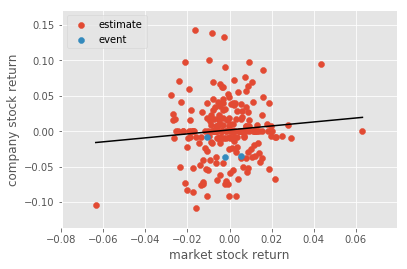

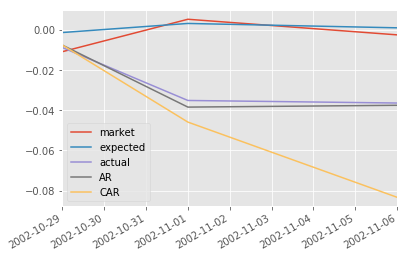

In [19]:
## (1つのエントリに対する) CAR の計算例
ret = calc_car("9993", pd.to_datetime("20021101"), exact = False, plot = True)   # 色々と(データの質的に)良くない適当な例
ret[4]   # summary (表)

## 1つ目の図は赤色が推定ウィンドウでのリターン、青色がイベントウィンドウでのリターン
## すなわち、赤色のデータを単回帰したものがマーケットモデル(黒線)になり、その直線から青色のデータ(の平均)が有意に離れているかを検定している

## XXX: プレスリリースが株価に「影響を及ぼしている」ことを言いたいのであれば、平均を取るよりも残差平方和(分散)の検定をした方が良いのでは？

## 2つ目の図はイベントウィンドウでの AR, CAR を含む各種数値の推移
## exact = False の場合は NaN のせいで3日よりも長い期間がプロットされることがあるが、実際にデータがあるのはこのうち 3日だけ

CAR = 0.0200399860441 (t値 = 0.293726079456)
推定ウィンドウ 開始日 2002-01-07, 終了日 2002-11-19
イベントウィンドウ 開始日 2003-01-06, 終了日 2003-01-08


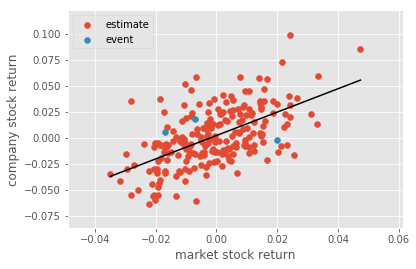

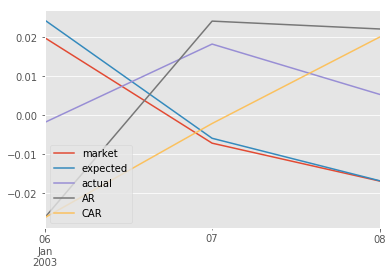

In [20]:
## もう一つ、実際のマッチング結果からの例
ret = calc_car("7951", pd.to_datetime("20030107"), exact = True, plot = True)

## プレスリリース発表当日にリターンが上昇しているが、 t値は有意には程遠い
## その原因としては、1) 検出力、2) マーケットモデルの分散が大きい、3) 平均を取っているのでマーケットモデルの上側と下側が相殺されている、等が考えられる

In [17]:
## matching データフレームの各行のデータから CAR を計算するラッパー
## パラメタのデフォルト値は上の calc_car のところにある
## (market_code = "1002", periods = (-246, -30, -1, 1) , exact = True, plot = False)

def mp_wrapper(args):   # 引数を展開するため
    data = args[1]
    article_id = data["article_id"]
    comp_code = str(data["comp_code"])
    date = pd.to_datetime(str(data["date"]))
    params = data["params"]
    market_code, periods, exact, plot = params
    prtype = pr_type[article_id] if article_id in pr_type else None   # タイプ情報が無いプレスリリースもたまに存在する
    return ((article_id, prtype, comp_code), calc_car(comp_code, date, market_code, periods, exact, plot))

def calc_car_df(matchings, n_core = 2, market_code = None, periods = None, exact = None, plot = None):    
    matchings_p = matchings.copy()
    matchings_p["params"] = Series([(market_code, periods, exact, plot)] * (matchings_p.index[-1] + 1))
    ## 元のデータフレームから(今回はスコアの閾値で)行を削除した場合、len(df) != df.index[-1] + 1 であることに注意
    
    car_all = pd.DataFrame()
    car_exist_set = set()   # すでに存在する結果を判定して重複を除く
    with Pool(n_core) as exe_pool:
        for ret in exe_pool.imap(mp_wrapper, matchings_p.iterrows()):
            if (ret[1] is not None) and (ret[0] not in car_exist_set):
                car, t_stat, window_stats, estimate_summary, event_summary = ret[1]
                estimate_market = " ".join(map(str, list(estimate_summary["market"])))   # 以下6つは出力用
                estimate_expected = " ".join(map(str, list(estimate_summary["expected"])))
                estimate_actual = " ".join(map(str, list(estimate_summary["actual"])))
                event_market = " ".join(map(str, list(event_summary["market"])))
                event_expected = " ".join(map(str, list(event_summary["expected"])))
                event_actual = " ".join(map(str, list(event_summary["actual"])))
                car_all = car_all.append([[*ret[0], car, t_stat, estimate_market, estimate_expected, estimate_actual, event_market, event_expected, event_actual]], ignore_index = True)
                car_exist_set.add(ret[0])
    car_all.columns = ["article_id", "pr_type", "comp_code", "car", "t_stat", "estimate_market", "estimate_expected", "estimate_actual", "event_market", "event_expected", "event_actual"]
    
    return car_all

In [18]:
## 全マッチング結果で計算(exact = True)
car_exactT_all = calc_car_df(matching, n_core = 7)

In [19]:
car_exactT_all[0:3]   # 中身の例

,article_id,pr_type,comp_code,car,t_stat,estimate_market,estimate_expected,estimate_actual,event_market,event_expected,event_actual
0,NIKPRLRSP038060_07012003,01: Product,7951,0.020040,0.293726,0.0011195870811 -0.0221487196012 -0.0065518477...,0.00337397871514 -0.0227087734798 -0.005225363...,0.0130522088353 -0.0317145688801 0.00818833162...,0.0198982556416 -0.00713895380609 -0.016839787...,0.0244240433074 -0.00588348373769 -0.016757693...,-0.00182315405652 0.0182648401826 0.0053811659...
1,NIKPRLRSP038615_16012003,04: Contract,6701,0.045907,0.719104,0.00743634731516 -0.00274399813692 0.023088638...,0.00644176939824 -0.00743111819057 0.027771347...,-0.043043812452 -0.0144578313253 0.01792991035...,0.0115380068566 0.000747960638571 0.0034450543034,0.0120311535713 -0.00267258108737 0.0010027831...,0.0204545454545 -0.00445434298441 0.0402684563758
2,NIKPRLRSP040660_17022003,01: Product,2284,-0.001984,-0.037386,-0.00156497703345 -0.000834605597964 -0.022125...,-0.000589628116902 -3.39680109377e-05 -0.01623...,-0.00568181818182 0.02 -0.0112044817927 0.0 0....,0.00590848876332 0.00425383136181 -0.005802483...,0.00509611833315 0.00383726966741 -0.003813485...,0.0149700598802 -0.00589970501475 -0.005934718...


In [20]:
## CAR 計算結果の出力
car_exactT_all.to_csv("car_exactT_all", sep = "\t", index = False)
# pd.read_csv("car_exactT_all", sep = "\t")   # 読み込み

## CAR 計算結果の確認

ここではプレスリリース本文の内容には踏み込まない。

### まずは、一番綺麗なデータ(東証一部だけ、株価データに NaN を含まない)だけの場合

In [80]:
## CAR が正方向に有意なものを調査

_deg_free = _periods[1] - _periods[0] + 1 - 2   # t検定の自由度のデフォルト値。上で定義した推定ウィンドウの初期値を使っている

def tvalue_to_pvalue(tvalue, deg_free = _deg_free, two_sided = False):
    pvalue = stats.t.sf(tvalue, deg_free)
    if two_sided == True:
        pvalue *= 2
    return pvalue

In [249]:
sig_threshold = 0.05   # 有意水準
car_exactT_sig = car_exactT_all[tvalue_to_pvalue(car_exactT_all["t_stat"]) < sig_threshold]   # 片側5%有意な CAR を持つデータの抽出
car_exactT_not_sig = car_exactT_all[tvalue_to_pvalue(car_exactT_all["t_stat"]) >= sig_threshold]   # 有意でない CAR を持つデータの抽出

In [250]:
print(len(car_exactT_sig), len(car_exactT_not_sig), len(car_exactT_all))

351 26494 26845


-> 26845個の CAR が計算できたエントリのうち、351個の CAR が片側5%で有意だった。(両側検定だと210個)

In [251]:
car_exactT_sig.iloc[:, 0:5].to_csv("car_exactT_sig", sep = "\t", index = False)   # リターンデータも出力したい場合は iloc による制限を消す
car_exactT_not_sig.iloc[:, 0:5].to_csv("car_exactT_not_sig", sep = "\t", index = False)

In [252]:
car_exactT_sig[0:3]   # 有意な CAR の例

,article_id,pr_type,comp_code,car,t_stat,window_dates,return_summary
43,NIKPRLRSP050445_10072003,01: Product,7911,0.104491,2.325275,"[2002-07-11 00:00:00, 2003-05-29 00:00:00, 200...",market(1002) expected actual(791...
90,NIKPRLRSP043991_04042003,06: Order,6366,0.236909,2.612091,"[2002-04-04 00:00:00, 2003-02-20 00:00:00, 200...",market(1002) expected actual(636...
125,NIKPRLRSP051415_24072003,02: Process,6305,0.150644,1.911461,"[2002-07-24 00:00:00, 2003-06-11 00:00:00, 200...",market(1002) expected actual(630...


CAR = 0.104491312777 (t値 = 2.3252754684)
推定ウィンドウ 開始日 2002-07-11, 終了日 2003-05-29
イベントウィンドウ 開始日 2003-07-09, 終了日 2003-07-11


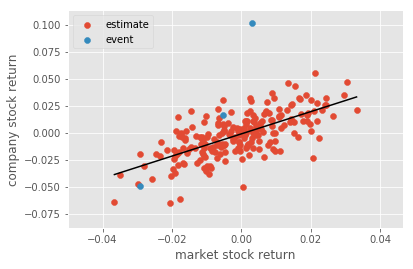

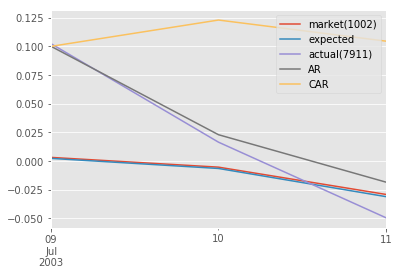

In [253]:
## 以下、有意な CAR のプロットを3例
ret = calc_car("7911", pd.to_datetime("20030710"), exact = True, plot = True)

CAR = 0.236908740793 (t値 = 2.61209064617)
推定ウィンドウ 開始日 2002-04-04, 終了日 2003-02-20
イベントウィンドウ 開始日 2003-04-03, 終了日 2003-04-07


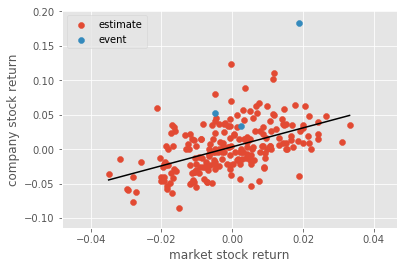

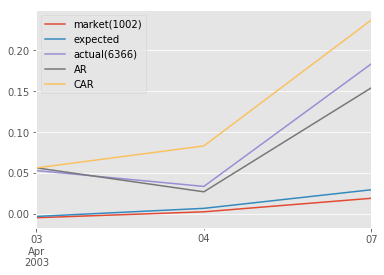

In [254]:
ret = calc_car("6366", pd.to_datetime("20030404"), exact = True, plot = True)

CAR = 0.112743009213 (t値 = 2.49234946709)
推定ウィンドウ 開始日 2002-11-13, 終了日 2003-09-30
イベントウィンドウ 開始日 2003-11-12, 終了日 2003-11-14


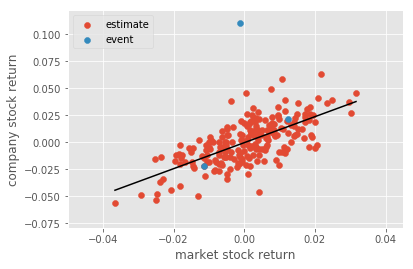

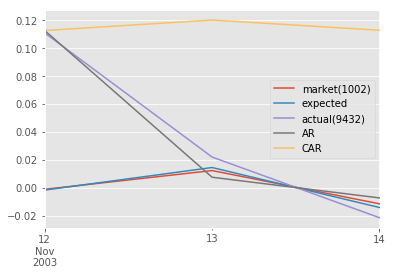

In [255]:
ret = calc_car("9432", pd.to_datetime("20031113"), exact = True, plot = True)

-> 1日だけ異常な値を示しているものが多い？

In [256]:
## 有意なプレスリリースをタイプ別に頻度を計上
type_count_sig = Counter(car_exactT_sig["pr_type"].value_counts().to_dict())

In [257]:
## 全プレスリリースについても同様にタイプ別に頻度を計上
type_count_all = Counter()
for prtype in pr_type.values():
    type_count_all[prtype] += 1

In [258]:
## プレスリリースの各タイプの数、割合をプロット
## 入力は {pr_type : count}

def del_anormal(count_data):    # 変な PR タイプの名前のデータを削除。リストと Counter の両方に対応
    if None in count_data:
        if isinstance(count_data, list):
            count_data.remove(None)
        else:
            del count_data[None]
    if "0" in count_data:
        if isinstance(count_data, list):
            count_data.remove("0")
        else:
            del count_data["0"]

def plot_type_hist(count_data):   # PR タイプのカウントデータをヒストグラムでプロット
    del_anormal(count_data)
    
    types = sorted(list(count_data.keys()))
    freqs = [int(count_data[x]) for x in types]
    
    xlab = np.arange(len(types))
    plt.figure(figsize=(16, 4))
    plt.bar(xlab, freqs, align = "center")
    plt.xticks(xlab, types, rotation = 90)

def plot_type_hist_multi(count_all, count_sig, sig_threshold = 0.05):   # 全 PR と、有意な CAR を持つ PR のタイプの割合をそれぞれ並べてプロット
    del_anormal(count_all)
    del_anormal(count_sig)
    
    types = sorted(list(count_all.keys()))
    freqs_all = np.array([count_all[x] for x in types])
    props_all = freqs_all / np.sum(freqs_all)
    freqs_sig = np.array([count_sig[x] for x in types])
    props_sig = freqs_sig / np.sum(freqs_sig)
    
    for i in range(len(types)):
        t = types[i]
        count_table = [[count_all[t], np.sum(freqs_all) - count_all[t]], [count_sig[t], np.sum(freqs_sig) - count_sig[t]]]
        odds_ratio, p_value = stats.fisher_exact(count_table)   # 割合の差を Fisher の正確確率検定で検定
        if p_value < sig_threshold:
            types[i] = "*" + t   # 有意な差を見せたタイプにはその名前の前に "*" を付ける

    w = 0.4
    xlab = np.arange(len(types))
    
    plt.figure(figsize = (16, 4))
    plt.bar(xlab, props_all, align = "center", width = w, color = "#e74c3c", label = "all PR")   # 赤色、全PR
    plt.bar(xlab + w, props_sig, align = "center", width = w, color = "#3498db", label = "PR with significant CAR")   # 青色、CARが有意なPR
    plt.xticks(xlab + w / 2, types, rotation = 90)
    plt.legend(loc = "upper right")

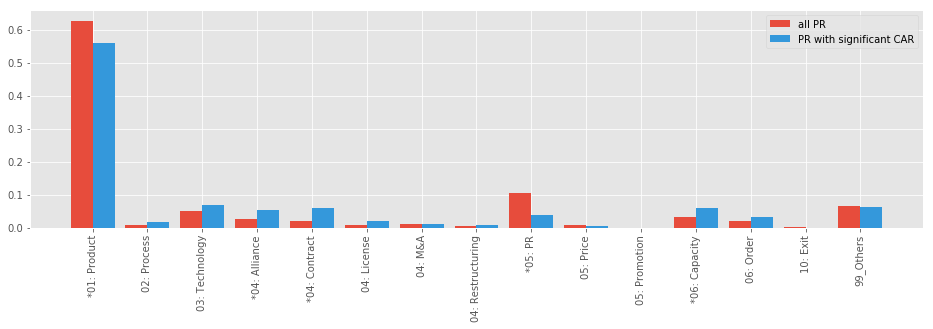

In [259]:
## PRタイプのヒストグラムの例。左側の赤色が全PRのタイプ別割合で、右側の青色が有意なCARを持つPRのタイプ別割合。
plot_type_hist_multi(type_count_all, type_count_sig)

-> Fisher の正確確率検定(5%, 多重検定補正無し)の結果だと、有意な CAR となる割合は、Alliance, Contract, Capacity で高く、Product, PR で低い。

In [260]:
## CAR の箱ひげ図

def plot_boxplot_all(car_all, car_sig, car_not_sig):   # 全部、有意なもの、有意でないもの    
    plt.figure(figsize = (16, 4))
    bp = plt.boxplot(list(reversed([car_all, car_sig, car_not_sig])), vert = False)   # 横にすると下から順に積み上げられるので反転
    plt.yticks([1, 2, 3], list(reversed(["All CARs", "Significant", "Not significant"])))
    
def plot_boxplot_among_types(car_all, sig_threshold = 0.05):   # タイプごと
    types = list(set(car_all["pr_type"]))
    del_anormal(types)
    types.sort()
    car_types = [list(car_all[car_all["pr_type"] == t]["car"]) for t in types]   # タイプごとの CAR データのリスト
    car_pvalues= [stats.ttest_1samp(x, 0)[1] if stats.ttest_1samp(x, 0)[0] != np.inf else 1.0 for x in car_types]   # 分散0の時はp値=1にする
    for i in range(len(types)):
        if car_pvalues[i] < sig_threshold:
            types[i] = "*" + types[i]
    
    plt.figure(figsize = (16, 10))
    bp = plt.boxplot(list(reversed(car_types)), vert = False)
    plt.yticks(np.arange(1, len(types) + 1), list(reversed(types)))

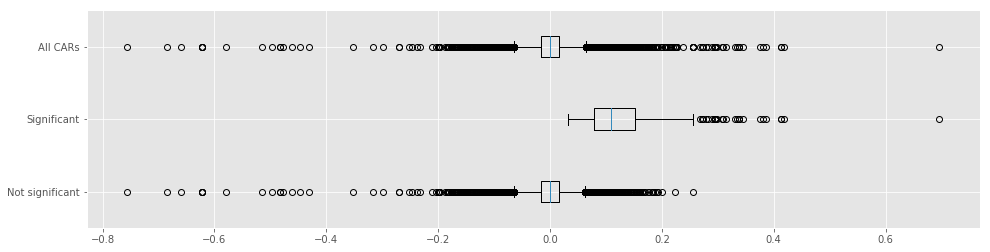

In [261]:
## CAR の全体的な傾向の確認
plot_boxplot_all(car_exactT_all["car"],car_exactT_sig["car"], car_exactT_not_sig["car"])

## 有意な CAR の平均は0.1 (10%)。値が高くても(マーケットモデルの分散が大きく)有意にならないものが意外とある

In [262]:
## CAR 全体で平均が0かどうか検定
print(np.mean(car_exactT_all["car"]))
stats.ttest_1samp(np.array(car_exactT_all["car"]), 0)

0.000871929491597


Ttest_1sampResult(statistic=3.6589969719800801, pvalue=0.00025368901133964253)

-> (平均は0.08%であるものの、)全体的にプレスリリースは CAR に正の影響を与えている。これは以前の結果とは異なる。マッチングの false-positive が減ったおかげ？

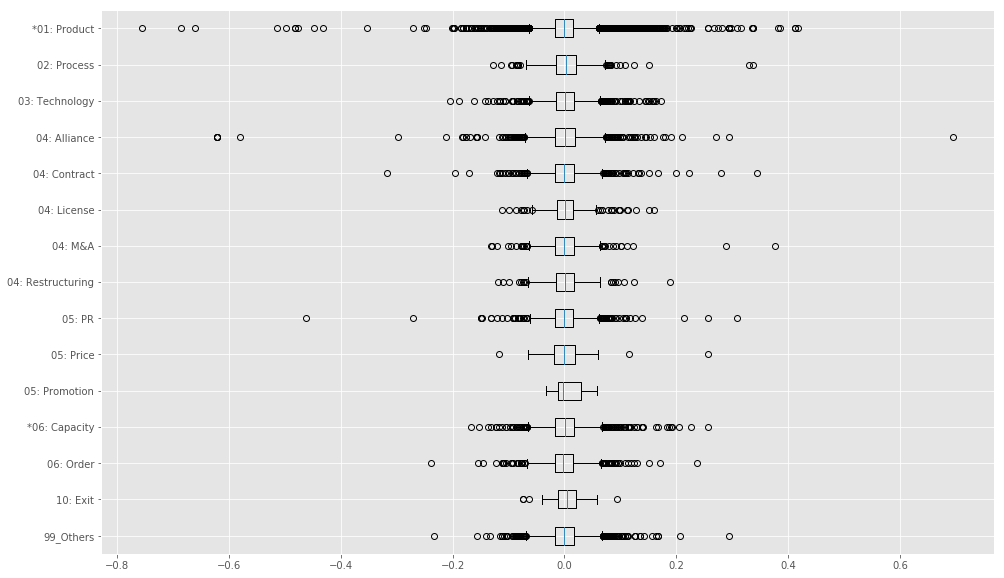

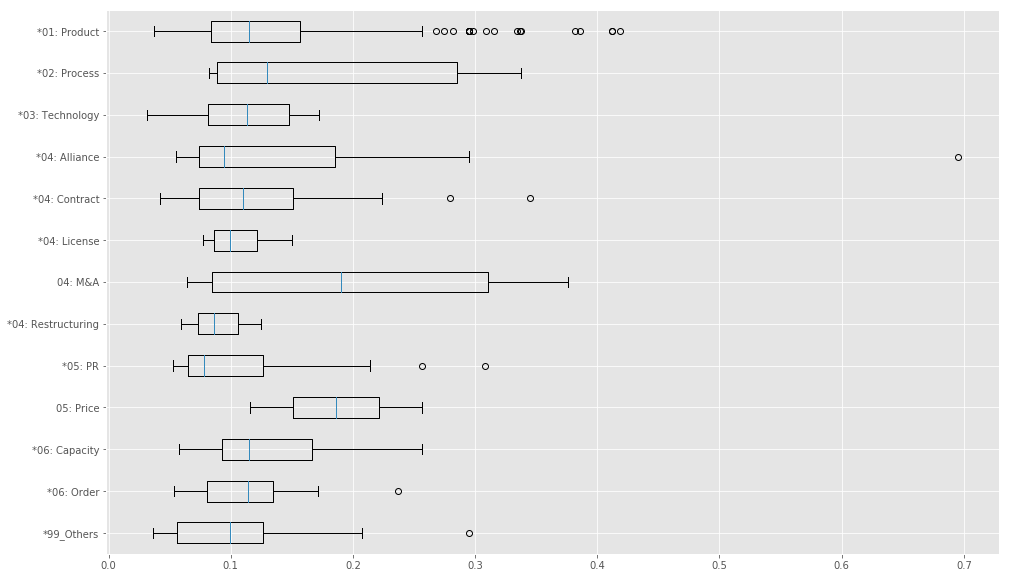

In [263]:
## PR タイプごとの CAR の傾向の確認。タイプ名の左の * は平均 != 0 が 5%有意を表す
plot_boxplot_among_types(car_exactT_all)   # 上図、全 PR
plot_boxplot_among_types(car_exactT_sig)   # 下図、有意な PR

### CAR の有意水準を片側10%にした場合

In [264]:
sig_threshold = 0.1   # 有意水準
car_exactT_sig = car_exactT_all[tvalue_to_pvalue(car_exactT_all["t_stat"]) < sig_threshold]   # 片側5%有意な CAR を持つデータの抽出
car_exactT_not_sig = car_exactT_all[tvalue_to_pvalue(car_exactT_all["t_stat"]) >= sig_threshold]   # 有意でない CAR を持つデータの抽出

In [265]:
print(len(car_exactT_sig), len(car_exactT_not_sig), len(car_exactT_all))

708 26137 26845


In [270]:
car_exactT_sig.iloc[:, 0:5].to_csv("car_exactT_alpha0.1_sig", sep = "\t", index = False)
car_exactT_not_sig.iloc[:, 0:5].to_csv("car_exactT_alpha0.1_not_sig", sep = "\t", index = False)

In [266]:
## 有意なプレスリリースをタイプ別に頻度を計上
type_count_sig = Counter(car_exactT_sig["pr_type"].value_counts().to_dict())

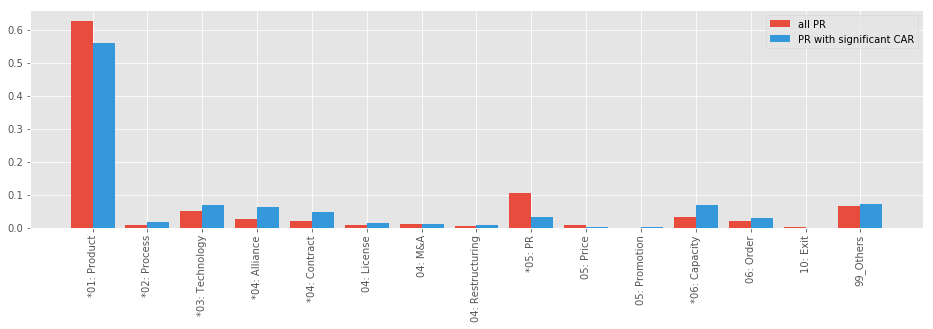

In [267]:
## PRタイプのヒストグラムの例。左側の赤色が全PRのタイプ別割合で、右側の青色が有意なCARを持つPRのタイプ別割合。
plot_type_hist_multi(type_count_all, type_count_sig)

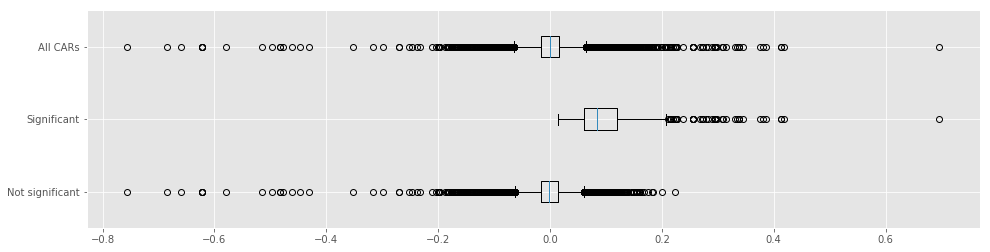

In [268]:
## CAR の全体的な傾向の確認
plot_boxplot_all(car_exactT_all["car"],car_exactT_sig["car"], car_exactT_not_sig["car"])

## 有意な CAR の平均は0.1 (10%)。値が高くても(マーケットモデルの分散が大きく)有意にならないものが意外とある

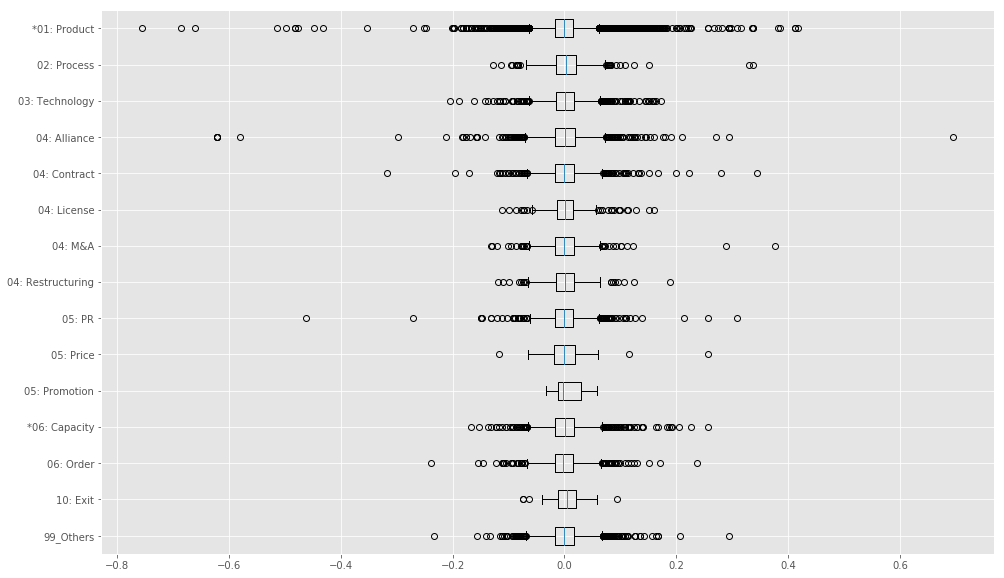

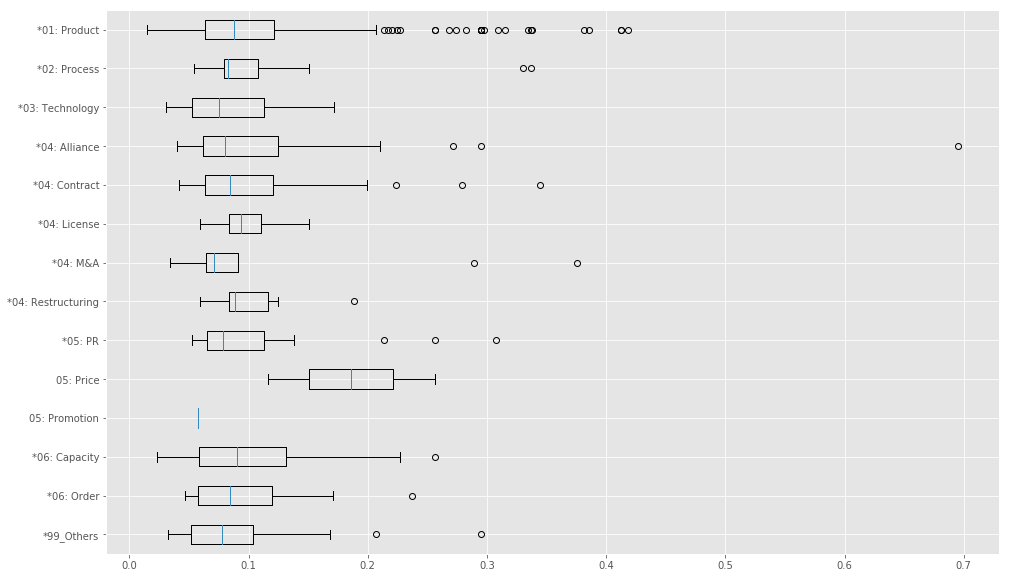

In [269]:
## PR タイプごとの CAR の傾向の確認。タイプ名の左の * は平均 != 0 が 5%有意を表す
plot_boxplot_among_types(car_exactT_all)   # 上図、全 PR
plot_boxplot_among_types(car_exactT_sig)   # 下図、有意な PR

### 株価データに NaN を含むものを許した(exact = False とした)場合

### 東証一部以外を含めた場合

### ウィンドウサイズを変更した場合

# TODO:

* 有意に負な CAR を見る